In [52]:
from radas import run_experiment, get_ray_results_dir  # pyright: ignore[reportMissingImports]
import ray.tune as tune
from v10_1_nlm_baseline import trainable_nonlinear_mapping
import torch
import pandas as pd
import numpy as np


results = await run_experiment(
    user_name="mengfan",
    experiment_name="nlm的baseline实验",
    param_space=dict(
        seed = tune.grid_search([1,2,3,4,5,6,7,8,9,10]),  
        # alpha_gen = tune.grid_search([round(x, 2) for x in np.arange(0, 0.11, 0.01)]),
        # alpha_disc = tune.grid_search([round(x, 1) for x in np.arange(0.1, 1.01, 0.1)]),
        epochs = tune.grid_search([100]),
        theta_optim = tune.grid_search(["AdamW"]),
        lr_theta = tune.grid_search([0.01,0.05,0.1]),
        use_bias = tune.grid_search([True,False]),

    ),
    # IMPORTANT: when using cluster, your trainable cannot be defined in this script, but has to be defined in a separate file, and imported in this script
    trainable=trainable_nonlinear_mapping,
    # When use cluster, local_storage_path needs to be specified in this way
    local_storage_path=get_ray_results_dir(),
    # Specify the cluster to use
    run_with="cluster:atol-gpu-5090",
    # Specify gram per trial
    cpu_per_trial=1,
    # If the gram_per_trial you set is larger than GRAM of a single GPU, you will be allocated with more than one GPUs
    # to fit your need. But in this case, you will need to handle how do you want to distribute your workload to these multiple GPUs
    # To check GRAM of a single GPU, use the following code:
    # from radas.clusters import gram_per_gpu
    #
    runtime_env={
        "pip": ["emoji","scikit-learn"],
        # for more runtime_env specifications, see https://docs.ray.io/en/latest/ray-core/handling-dependencies.html#api-reference
    },
    #
    instant_gpu_allocation=1,
)

[INFO]: Checking if the experiment exists...
[Choices]: Choose an option by number:
[1]: run -- Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
 2 : restore -- Restore an existing experiment from the storage (if there is a running experiment, it will be stopped)
 3 : attach -- Attach to a running experiment
 4 : stop_attach -- Stop and attach to a running experiment
>>> [1]: Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
[INFO]: 🚀 正在测试代理连接...
[INFO]: ✅ 代理连接成功


2025-12-26 10:09:21,613	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_69ab55b71e989f5b.zip.
2025-12-26 10:09:21,615	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/projects/BiPCN/BiPCN/v10'.
2025-12-26 10:09:21,704	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_4588c91f8f921f3a.zip.
2025-12-26 10:09:21,706	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/repos/radas/radas/'.


[INFO]: Submitting job...
[INFO]: Job submitted.
[INFO]: Tailing experiment logs below 👇👇👇
2025-12-25 21:09:21,769	INFO job_manager.py:531 -- Runtime env is setting up.

  0%|          | 0/364 [00:00<?, ?file/s]
rm_local_folder: mengfan/nlm的baseline实验/trainable_nonlinear_mapping_56574_00001_1_epochs=100,lr_theta=0.0500,seed=1,theta_optim=SGD,use_bias=True_2025-12-25_20-51-04/events.out.tfevents.1766713876.atol-gpu-5090-head:   0%|          | 0/364 [00:00<?, ?file/s]
rm_local_folder: mengfan/nlm的baseline实验/trainable_nonlinear_mapping_56574_00001_1_epochs=100,lr_theta=0.0500,seed=1,theta_optim=SGD,use_bias=True_2025-12-25_20-51-04/params.pkl:   0%|          | 0/364 [00:00<?, ?file/s]                                       
rm_local_folder: mengfan/nlm的baseline实验/trainable_nonlinear_mapping_56574_00001_1_epochs=100,lr_theta=0.0500,seed=1,theta_optim=SGD,use_bias=True_2025-12-25_20-51-04/params.json:   0%|          | 0/364 [00:00<?, ?file/s]
rm_local_folder: mengfan/nlm的baseline实验/trainable

In [53]:
results["df"]
df = results["df"]

Available epoch metrics: ['test_acc', 'test_loss', 'train_loss']


ValueError: No columns for metric='E_train_after_infer'. Expected epoch_k/E_train_after_infer

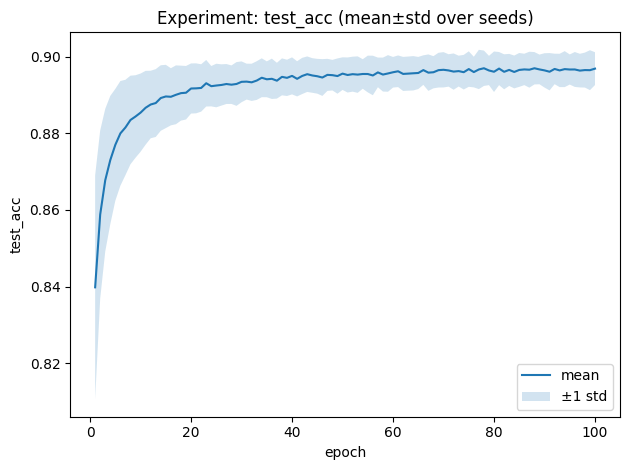

In [54]:
from v10_1_visual import plot_experiment_results
plot_experiment_results(df)

In [ ]:
results["df"]


In [55]:
# 1. 筛选 config/use_bias = True ,lr_theta = 0.01的
filtered_df = df[df["config/use_bias"] == True]
filtered_df = filtered_df[filtered_df["config/lr_theta"] == 0.01]

# 2. 提取筛选后的数据列（final/test_acc）
final_test_acc_col = filtered_df["final/test_acc"]
print("筛选后的 final/test_acc 列：")
print(final_test_acc_col)

# 3. 计算百分比形式的均值和标准差
if not final_test_acc_col.empty:
    # 转百分比（×100）
    acc_mean_pct = final_test_acc_col.mean() * 100
    acc_std_pct = final_test_acc_col.std() * 100

    # 4. 标准格式输出（控制台文本版）
    print("筛选后的 final/test_acc 列（原始值）：")
    print(final_test_acc_col)
    print(f"\n最终测试准确率：{acc_mean_pct:.2f} ± {acc_std_pct:.2f} %")

    # 可选：LaTeX/Markdown文档版（复制到论文/报告中，支持上标）
    print(f"LaTeX格式（粘贴到论文）：${acc_mean_pct:.2f} \\pm {acc_std_pct:.2f}\\%$")
else:
    print("筛选后无有效数据，无法计算均值和标准差！")

筛选后的 final/test_acc 列：
0     0.9022
1     0.8936
3     0.8961
7     0.8932
16    0.8963
25    0.8982
31    0.8959
41    0.9005
49    0.9035
51    0.9016
Name: final/test_acc, dtype: float64
筛选后的 final/test_acc 列（原始值）：
0     0.9022
1     0.8936
3     0.8961
7     0.8932
16    0.8963
25    0.8982
31    0.8959
41    0.9005
49    0.9035
51    0.9016
Name: final/test_acc, dtype: float64

最终测试准确率：89.81 ± 0.37 %
LaTeX格式（粘贴到论文）：$89.81 \pm 0.37\%$
